## Thông tin sinh viên

- Họ và tên: Đinh Vũ Gia Hân
- MSSV: 22127098
- Lớp: 22CLC08

## Import các thư viện liên quan

In [1]:
import numpy as np                                                  
from PIL import Image                       
import matplotlib.pyplot as plt             

## Helper functions

In [85]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    # YOUR CODE HERE
    try:
        img_2d = Image.open(img_path)
    except FileNotFoundError:
        print("ERROR: File not found")
        return None
    except plt.UnidentifiedImageError:
        print("ERROR: Invalid image")
        return None
    except:
        print("ERROR: Unknown error")
        return None

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img_2d)
    plt.axis('off')
    plt.tight_layout()

    return img_2d

def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    '''

    # YOUR CODE HERE
    plt.subplot(1, 2, 2)
    plt.title("Compressed Image")
    plt.imshow(img_2d)
    plt.axis('off')
    plt.tight_layout()


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    print("Enter the output format (1 = JPG, 2 = PNG, 3 = PDF): ")
    choice = int(input())
    if choice == 1:
        type = 'JPG'
    elif choice == 2:
        type = 'PNG'
    elif choice == 3:
        type = 'PDF'
    else:
        print("Invalid choice")
        return
        
    img = Image.fromarray(img_2d, 'RGB')
    img.save(img_path.split('.')[0] + '_compressed.' + type.lower())
    print("Image saved successfully")

def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    # YOUR CODE HERE
    img_1d = np.array(img_2d)
    img_height, img_width, num_channels = img_1d.shape
    img_1d = img_1d.reshape((img_height * img_width, num_channels))

    return img_1d

def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    
    # YOUR CODE HERE
    # init centroids with random values in [0, 255]
    if init_centroids == 'random':
        centroids = np.random.randint(0, 255, size = (k_clusters, img_1d.shape[1]))
    # init centroids with random pixels in the image
    elif init_centroids == 'in_pixels':
        centroids = img_1d[np.random.choice(img_1d.shape[0], size = k_clusters, replace = False)]
    
    pre_labels = []
    for i in range(max_iter):
        # distance between each pixel and each centroid
        distances = np.linalg.norm(img_1d - centroids[:, np.newaxis], axis = 2)
        # find the label of each pixel
        labels = np.argmin(distances, axis = 0)

        # calculate the mean of each cluster
        means = []
        for j in range(k_clusters):
            if len(img_1d[labels == j]):
                means.append(img_1d[labels == j].mean(axis = 0))
            else:
                means.append(np.zeros(img_1d.shape[1]))

        # if the labels are not changed, break the loop
        if all(pre_labels) == all(labels):
            break

        # update the centroids
        means = np.array(means)
        for i in range(k_clusters):
            if len(means[i]) != 0:
                centroids[i] = means[i]

        # store the previous labels
        pre_labels = labels.copy()
    
    return centroids, labels

def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''

    # YOUR CODE HERE
    img_height, img_width, num_channels = img_2d_shape
    output_img = np.zeros((img_height * img_width, num_channels))

    # reassign labels to the pixels
    for i in range(centroids.shape[0]):
        output_img[labels == i] = centroids[i]
        
    output_img = output_img.astype("uint8")
    output_img = output_img.reshape(img_height, img_width , num_channels)

    return output_img

# Your additional functions here
def color_compression(img_path, k_clusters, max_iter, init_centroids):
    '''
    Color compression algorithm

    Parameters
    ----------
    img_path : str
        Path of image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster
    '''
    
    # YOUR CODE HERE
    if k_clusters <= 0:
        print("ERROR: Invalid number of clusters")
        return
    if max_iter <= 0:
        print("ERROR: Invalid number of iterations")
        return
    if init_centroids not in ['random', 'in_pixels']:
        print("ERROR: Invalid initialization method")
        return
    
    img_2d = read_img(img_path)
    img_2d_shape = np.array(img_2d).shape
    img_1d = convert_img_to_1d(img_2d)

    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids)
    new_img = generate_2d_img(img_2d_shape, centroids, labels)
 
    show_img(new_img)
    save_img(new_img, img_path)

## Your tests

## Main FUNCTION

In [31]:
# YOUR CODE HERE
def main():
    print("Enter image path: ")
    img_path = input()

    print("Enter number of clusters: ")
    k_clusters = int(input())

    print("Enter maximum number of iterations: ")
    max_iter = int(input())

    print("Enter method to initialize centroids ('in_pixels' or 'random'): ")
    init_centroids = input()
    
    color_compression(img_path, k_clusters, max_iter, init_centroids)

Enter image path: 
Enter number of clusters: 
Enter maximum number of iterations: 
Enter method to initialize centroids ('in_pixels' or 'random'): 
Enter the output format (1 = JPG, 2 = PNG, 3 = PDF): 
Image saved successfully


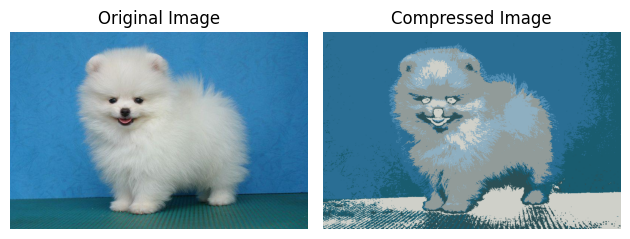

In [86]:
# Call main function
main()